In [2]:
import os

import matplotlib.pyplot as plt

os.chdir("../src")

from predictor import lstm

SEQ_LEN=15

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error.

projects/harambe-6/locations/global/keyRings/harambe-6-dev/cryptoKeys/harambe-6-dev-key


In [3]:
# get Microsoft's stock opening prices and create list of 15 day frames
times = lstm.get_time_series_daily("AAPL", filters=["1. open"], outputsize="full")
# times = lstm.get_time_series_daily("MSFT", filters=["4. close", "5. volume"], outputsize="full")
# times are returned descending from most recent so should be reversed
vectors = lstm.times_to_vectors(times)[::-1]
frames = lstm.get_frames(vectors, seq_len=SEQ_LEN, with_target=True) # each frame is 15+1 (trend length + prediction target) vectors

print(f"last frame: {frames[-1]}")
print(f"last target frame: {frames[-1][-1]}")

last frame: [['176.4200'], ['177.9500'], ['176.2300'], ['175.6000'], ['175.4400'], ['184.2800'], ['183.0800'], ['186.5100'], ['191.8100'], ['194.8600'], ['193.9500'], ['194.7000'], ['191.5450'], ['192.9000'], ['196.0500'], ['199.6800']]
last target frame: ['199.6800']


In [3]:
# seperate normalized frames into training and testing data
train, test = lstm.partition_data(frames, partition_coefficient=0.8)
# split training and testing data into sequences and their targets
train_x, train_y = lstm.seperate_xy(lstm.normalize_frames(train))
# train_y = [[target[0]] for target in train_y]

test_x, test_y = lstm.seperate_xy(lstm.normalize_frames(test))
# test_y = [[target[0]] for target in test_y]

print(f"training sequence 1: {train_x[0]}, target: {train_y[0]}")
print(f"testing sequence 1: {test_x[0]}, target: {test_y[0]}")

training sequence 1: [[0.0], [-0.016468962340204896], [-0.028976160313255783], [-0.031970517102383966], [-0.06716572613152128], [-0.10636876655533789], [-0.09561211562823912], [-0.06946907750777376], [-0.0935390993896118], [-0.05280433030058729], [-0.05606357249798455], [-0.0315559138546585], [0.002188183807440014], [0.023747552689162843], [0.017574571000806172]], target: [0.03952550961649215]
testing sequence 1: [[0.0], [0.0], [-0.012247958673554438], [0.0012497917013831739], [0.02291284785869019], [0.05032494584235958], [0.060489918346942284], [0.062239626728878505], [0.06336443926012336], [0.07048825195800701], [0.0716547242126313], [0.0833194467588736], [0.10764872521246471], [0.09615064155974018], [0.07302949508415257]], target: [0.08315280786535584]


In [10]:
# create LSTM model using the training data
MODEL_FILE='demo.h5'
from keras.models import load_model

try:
    model = load_model(MODEL_FILE)
    print(f"found model file {MODEL_FILE}")
except OSError:
    model = lstm.setup_lstm_model(train_x, train_y)

print(model)
model.save(MODEL_FILE)

In [13]:
# predict results using the test data
predictions = lstm.predict_sequences_multiple(model, test_x)

In [12]:
# update model with test data and targets
x_test_np = lstm.frames_to_np_array(test_x)
y_test_np = lstm.frames_to_np_array(test_y)

model.fit(
    x_test_np,
    y_test_np,
    batch_size=512,
    epochs=1,
    validation_split=0.05
)

model.save(MODEL_FILE)

Train on 1023 samples, validate on 54 samples
Epoch 1/1
1023/1023 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0014


final sequence: [[0.0], [-0.01569164341003626], [-0.033647517245010694], [-0.024695908588278637], [-0.027644673792849295], [-0.053235743246801026], [-0.05112948238639359], [-0.05786951713969779], [-0.07103364751724506], [-0.0629771997261861], [-0.07203412142593868], [-0.07535148228108057], [-0.07619398662524357], [-0.029645621610236428], [-0.035964404191459076]]
predicted: [-0.0606201]
actual: [-0.017903217313464337]


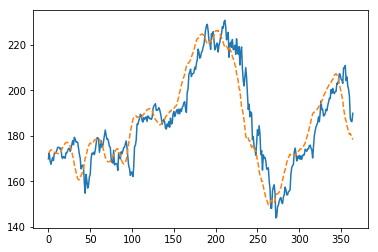

Next predicted normalized value:
current: 186.5100
next predicted: 178.80084742829203


In [14]:
print(f"final sequence: {test_x[-1]}")
print(f"predicted: {predictions[-1]}")
print(f"actual: {test_y[-1]}")
# plot the results of the last month
# (dashed line is prediction)
def plot_results_multiple(predicted_data, frames):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)

    targets = [float(frame[0][0]) for frame in frames]
    denormalized_predictions = [
        lstm.denormalize_dim(prediction[0], targets[i])
        for i, prediction in enumerate(predicted_data)
    ]

    ax.plot(targets, label="Actual")

    plt.plot(
        denormalized_predictions,
        label="Predicted",
        linestyle="dashed"
    )

    plt.show()

plot_results_multiple(predictions[-365:], test[-365:])

# get next prediction:
next_seq = frames[-1][-SEQ_LEN:]
current_val = next_seq[-1]
next_predicted = lstm.predict_sequences_multiple(model, [lstm.normalize_frame(next_seq)])
print("Next predicted normalized value:")
print(f"current: {current_val[0]}")
print(f"next predicted: {lstm.denormalize_dim(next_predicted[0][0], next_seq[0][0])}")